In [1]:
import pandas as pd
import numpy as np
import math
import scipy.optimize as opt
import quantstats as qs
import matplotlib.pyplot as plt

In [2]:
# Data: Close
db = pd.read_excel('Data.xlsx', index_col = "Date")

# MSD

In [3]:
db.index = pd.to_datetime(db.index)
MSD_df = db['2006':'2013']
MSD_df = (MSD_df-MSD_df.mean())/MSD_df.std() #change rolling
MSD_df = MSD_df.dropna(axis = 1) #drop nan

In [4]:
target = {}
for i in range(0,len(MSD_df.columns)-1):
    for j in range(i+1,len(MSD_df.columns)):
        tmp = ((MSD_df.iloc[:,i] - MSD_df.iloc[:,j])**2).sum()
        target[str(MSD_df.columns[i])+','+str(MSD_df.columns[j])] = tmp

In [5]:
target_df = pd.DataFrame.from_dict(target, orient='index')
target_df = target_df.sort_values(by = 0)[0:10]
target_df.columns = ['MSD']
target_df

,MSD
"DIS,TRV",106.019533
"IBM,MCD",174.553811
"AAPL,IBM",183.653680
"CVX,KO",205.031258
"IBM,KO",225.295065
"DIS,HD",264.348677
"HD,TRV",282.786437
"PEP,PG",298.596370
"DIS,MMM",300.548727
"GOOGL,TRV",304.718140


In [6]:
# pair1_df_train = db.loc["2006":"2013",target_df.index[0].split(",")].pct_change(1).dropna()
# pair1_df_test = db.loc["2014":"2014",target_df.index[0].split(",")].pct_change(1).dropna()
# pair9_df_train = db.loc["2006":"2013",target_df.index[8].split(",")].pct_change(1).dropna()
# pair9_df_test = db.loc["2014":"2014",target_df.index[8].split(",")].pct_change(1).dropna()
# pair10_df_train = db.loc["2006":"2013",target_df.index[9].split(",")].pct_change(1).dropna()
# pair10_df_test = db.loc["2014":"2014",target_df.index[9].split(",")].pct_change(1).dropna()
# pair4_df_train = db.loc["2006":"2013",target_df.index[3].split(",")].pct_change(1).dropna()
# pair4_df_test = db.loc["2014":"2014",target_df.index[3].split(",")].pct_change(1).dropna()
# pair1_df_test

# MLE

In [7]:
import random
random.seed(108)

def fun_MLE(x):
    fi_1_0, fi_1_1, fi_2_0, fi_2_1, alpha_1_0, alpha_1_1, beta_1_1, alpha_2_0, alpha_2_1, beta_2_1, gamma, c_1, c_2= x
    # Define h_t1
    tmp = 30
    target = 0
    z_td = pair1_df_train.iloc[0:tmp,0]-pair1_df_train.iloc[0:tmp,1]
    z_td = z_td.to_numpy()
    s_z = z_td.std()
    Fdis = (1+np.exp(-gamma*(z_td[-1] - c_1)*(z_td[-1] - c_2)/s_z))**(-1)
    h_1_t = pair1_df_train.iloc[0:tmp,0].std()
    h_2_t = pair1_df_train.iloc[0:tmp,1].std()
    h_t1 = h_1_t + Fdis*h_2_t
    epsilon = random.gauss(mu = 0, sigma = 1)
    a_t1 = h_t1**0.5*epsilon #error term


    y_t1 = pair1_df_train.iloc[tmp-1,0] - pair1_df_train.iloc[tmp-1,1]
    # Define sigma, real_y_t, y_t
    for i in range(tmp,len(pair1_df_train)):
        z_td = pair1_df_train.iloc[0:i,0]-pair1_df_train.iloc[0:i,1]
        z_td = z_td.to_numpy()
        s_z = z_td.std()
        real_y_t = pair1_df_train.iloc[i,0] - pair1_df_train.iloc[i,1]
        # real_y_t = real_y_t.to_numpy()
        h_1_t = alpha_1_0 + alpha_1_1*a_t1**2 + beta_1_1*h_t1
        h_2_t = alpha_2_0 + alpha_2_1*a_t1**2 + beta_2_1*h_t1
        miu_1 = fi_1_0 + fi_1_1*y_t1
        miu_2 = fi_2_0 + fi_2_1*y_t1
        h_t = h_1_t + Fdis*h_2_t
        epsilon = random.gauss(mu = 0, sigma = 1)
        a_t = h_t**0.5*epsilon #error term
        y_t = miu_1 + Fdis*miu_2 + a_t #ST-GARCH

        h_t1 = h_t
        a_t1 = a_t
        y_t1 = real_y_t

        sigma = h_t
        target += np.log((2*np.pi*sigma**2)**(-0.5)*np.exp(-(real_y_t-y_t)**2/(2*sigma**2))) #MLE
        # print(target)
    target = -target
    return target

In [ ]:
#MLE
tmp = 1e-9*4
initial = np.array([0.1068, 0.3838, 0.0940, -0.2366, 0.1649, 0.2062, 0.6622, -0.1045, -0.0981, -0.1827, 4.9262, -0.3516, 0.3068])
b1 = ((pair1_df_train.iloc[:30,0] - pair1_df_train.iloc[:30,1]).std())**2*10000 #假設, 原sy^2
b2 = 1
b3 = 1.1
constraints = ( {'type':'ineq','fun':lambda x : x[4]+tmp},
                {'type':'ineq','fun':lambda x: x[5]+tmp},
                {'type':'ineq','fun':lambda x: x[6]+tmp},
                {'type':'ineq','fun':lambda x: x[5]+x[8]+tmp},
                {'type':'ineq','fun':lambda x: x[6]+x[9]+tmp},
                {'type':'ineq','fun':lambda x:-x[5]-0.5*x[8]-x[6]-0.5*x[9]+1+tmp},
                {'type':'ineq','fun':lambda x:-x[4]+b1+tmp}, #b1
                {'type':'ineq','fun':lambda x:-x[6]+b2+tmp}, #b2 = 1
                {'type':'ineq','fun':lambda x:-x[5]-x[6]+b3+tmp},#b3 = 1.1
                {'type':'ineq','fun':lambda x: x[12]-x[11]+tmp}
                )
bound = (-0.9,0.9)
# bounds = tuple(bound for asset in range(len(initial)))
bounds = ((-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-0.9, 0.9),
            (-5, 5),
            (-0.9, 0.9),
            (-0.9, 0.9))
minimum = opt.minimize(fun_MLE, initial, constraints = constraints, method = 'trust-constr', bounds = bounds) #bounds: 0.9
minimum

In [ ]:
minimum.x

In [8]:
# MLE估出來的參數們
c1 = [-0.31465486, -0.33643076, -0.2989415, -0.4611008, -0.32515204, -3.43630713e-01, -3.85909912e-01, -0.2276087, -0.44683943, -0.16195012]
c2 = [0.33141209, 0.44169301, 0.41113809, 0.54846773,  0.28668117, 2.56465630e-01, 3.10899847e-01, 0.43567054, 0.59456784, 0.3972846]

target_df['stategy1_upper'] = c2
target_df['stategy1_lower'] = c1

target_df

,MSD,stategy1_upper,stategy1_lower
"DIS,TRV",106.019533,0.331412,-0.314655
"IBM,MCD",174.553811,0.441693,-0.336431
"AAPL,IBM",183.653680,0.411138,-0.298942
"CVX,KO",205.031258,0.548468,-0.461101
"IBM,KO",225.295065,0.286681,-0.325152
"DIS,HD",264.348677,0.256466,-0.343631
"HD,TRV",282.786437,0.310900,-0.385910
"PEP,PG",298.596370,0.435671,-0.227609
"DIS,MMM",300.548727,0.594568,-0.446839
"GOOGL,TRV",304.718140,0.397285,-0.161950


# VaR

In [9]:
def VaR_VCM(rp,vp,x,n): #value
    '''標準差法
    value: 投組價值
    rp: 日平均報酬率的差
    vp: 日平均報酬率的差的報酬率
    x: 信心水準
    n: 天數
    '''
    import scipy.stats as st
    import numpy as np
    z = np.abs(st.norm.ppf(q=1-x)) #計算常態分配下1-x的分位數並取正數
    pct_upper = np.sqrt(n)*(rp+z*vp)
    pct_lower = np.sqrt(n)*(rp-z*vp)

    return  pct_upper, pct_lower #np.sqrt(n)*value*(z*vp-rp)

In [10]:
def VaR_HIS(r_his,x,n): #value
    '''歷史模擬法
    value: 投組價值
    r_his: 過去所有報酬率的集合
    x: 信心水準
    n: 天數
    '''
    import numpy as np
    pct_upper = np.percentile(a = r_his, q=(x)*100)*np.sqrt(n)
    pct_lower = np.percentile(a = r_his, q=(1-x)*100)*np.sqrt(n)
    
    return  pct_upper, pct_lower

# 所有配對之三個方法的上下界

In [11]:
#逐個配對計算
for i in range(len(target_df)): #len(target_df)
    pairlist = target_df.index[i].split(",")
    pairname = pairlist[0]+"-"+pairlist[1]
   
    #算配對組合的各別報酬率
    pair_df_train = db.loc["2006":"2013",pairlist].pct_change(1).dropna()
    #pair_df_test = db.loc["2014":"2014",pairlist].pct_change(1).dropna()

    #算配對組合報酬率的差 yt = ra-rb
    pair_df_train[pairname] = pair_df_train[pairlist[0]] - pair_df_train[pairlist[1]]
    #pair_df_test[pairname] = pair_df_test[pairlist[0]] - pair_df_test[pairlist[1]]
    pair_mean = pair_df_train[pairname].mean()
    pair_std = pair_df_train[pairname].std()

    #VaR_VCM
    pair_VCM80, pair_VCM20 = VaR_VCM(pair_mean,pair_std,0.8,1)
    pair_VCM90, pair_VCM10 = VaR_VCM(pair_mean,pair_std,0.9,1)

    #VaR_HIS
    #r_his = pair_df_train[pairname] #配對組合報酬率的差歷史資料
    #pair_HIS80, pair_HIS20 = VaR_HIS(r_his,0.8,1)
    #pair_HIS90, pair_HIS10 = VaR_HIS(r_his,0.9,1)
    
    target_df.loc[target_df.index[i],'stategy2_upper'] = pair_VCM80*100
    target_df.loc[target_df.index[i],'stategy2_lower'] = pair_VCM20*100
    target_df.loc[target_df.index[i],'stategy3_upper'] = pair_VCM90*100
    target_df.loc[target_df.index[i],'stategy3_lower'] = pair_VCM10*100
target_df

,MSD,stategy1_upper,stategy1_lower,stategy2_upper,stategy2_lower,stategy3_upper,stategy3_lower
"DIS,TRV",106.019533,0.331412,-0.314655,1.542434,-1.501958,2.338113,-2.297637
"IBM,MCD",174.553811,0.441693,-0.336431,1.175117,-1.193971,1.794299,-1.813153
"AAPL,IBM",183.653680,0.411138,-0.298942,1.780813,-1.630546,2.672402,-2.522135
"CVX,KO",205.031258,0.548468,-0.461101,1.318030,-1.295942,2.001214,-1.979126
"IBM,KO",225.295065,0.286681,-0.325152,1.176860,-1.159058,1.787373,-1.769570
"DIS,HD",264.348677,0.256466,-0.343631,1.430886,-1.384494,2.166710,-2.120319
"HD,TRV",282.786437,0.310900,-0.385910,1.604358,-1.610273,2.444530,-2.450445
"PEP,PG",298.596370,0.435671,-0.227609,0.893398,-0.893649,1.360459,-1.360709
"DIS,MMM",300.548727,0.594568,-0.446839,1.255019,-1.185292,1.892816,-1.823089
"GOOGL,TRV",304.718140,0.397285,-0.161950,1.851141,-1.824766,2.811872,-2.785496


In [14]:
def trade(y1, bound, p1, p2, i, t):
    # Input1 : Real return spread
    # Input2 : Estimated return spread
    # Output : Gain, Trading Signal

    #signal
    #tmp0 = 0 # 不動作
    tmp1 = 1 # 賣A買B
    tmp2 = -1 # 買A賣B

    #First trade
    if results['i'][-1] == 0: # 上一筆未交易
        if (y1 > bound[0]): # spread 高於上界
            # print('a') # 路徑 a
            signal = tmp1 # 賣A買B
            results['A_SoldPrices'].append(p1) # A 賣價
            results['B_BoughtPrices'].append(p2) # B 買價
            results['i'].append(1) # 已交易
            results['signals'].append(signal)
            results['signal_times'].append(t)
            tmp = 0 # 報酬 0
            # print(results['i'])
            # print(results['signals'])

        elif (y1 < bound[1]): # spread 小於下界
            # print('b') # 路徑 b
            signal = tmp2 # 買A賣B
            results['A_BoughtPrices'].append(p1) # A 買價
            results['B_SoldPrices'].append(p2) # B 賣價
            results['i'].append(1) # 已交易
            results['signals'].append(signal)
            results['signal_times'].append(t)
            tmp = 0 # 報酬 0
            # print(results['i'])
            # print(results['signals'])

        else: # spread 在上下界之間
            # print('c') # 路徑 c
            #signal = tmp0 # 不動作
            tmp = 0  # 報酬 0
            results['i'].append(0) # 未交易
            #results['signals'].append(signal)
            # print(results['i'])

    elif results['i'][-1]  == 1: # 已交易過
        results['i'].append(1)  # 已交易過
        # print(results['i'])
        # After first trade
        if (y1 > bound[0]) and (results['signals'][-1] == tmp2) : # spread 高於上界 且上次 買A賣
        #if (y1 > bound[0]) and ((sum(results['signals']) == tmp2) or (sum(results['signals']) == tmp0)):
            # print('d') # 路徑 d
            signal = tmp1 # 賣A買B
            results['signals'].append(signal)
            results['signal_times'].append(t)
            results['A_SoldPrices'].append(p1) # A 賣價
            results['B_BoughtPrices'].append(p2) # B 買價
            tmp = np.log(results['A_SoldPrices'][-1]/results['A_BoughtPrices'][-1])-np.log(results['B_SoldPrices'][-1]/results['B_BoughtPrices'][-1])
            # 算報酬率
            # print(results['signals'])

        elif (y1 < bound[1]) and (results['signals'][-1] == tmp1) : # spread 小於下界 且上次 賣A買B
            # print('e') # 路徑 e
            signal = tmp2 # 買A賣B
            results['signals'].append(signal)
            results['signal_times'].append(t)
            results['A_BoughtPrices'].append(p1) # A 買價
            results['B_SoldPrices'].append(p2) # B 賣價
            # tmp = np.log(results['A_SoldPrices'][-1]/results['A_BoughtPrices'][-1])-np.log(results['B_SoldPrices'][-1]/results['B_BoughtPrices'][-1])
            tmp = -np.log(results['A_SoldPrices'][-1]/results['A_BoughtPrices'][-1])+np.log(results['B_SoldPrices'][-1]/results['B_BoughtPrices'][-1])
            # 算報酬率
            # print(results['signals'])

        else: # spread 高於上界 且上次 賣A買B or spread 小於下界 且上次 買A賣B 
            # print('f')
            #signal = tmp0 # 不動作
            #results['signals'].append(signal)
            tmp = 0  # 報酬 0


    #results['signals'].append(signal)
    results['returns'].append(tmp)
    return 0

# Trade

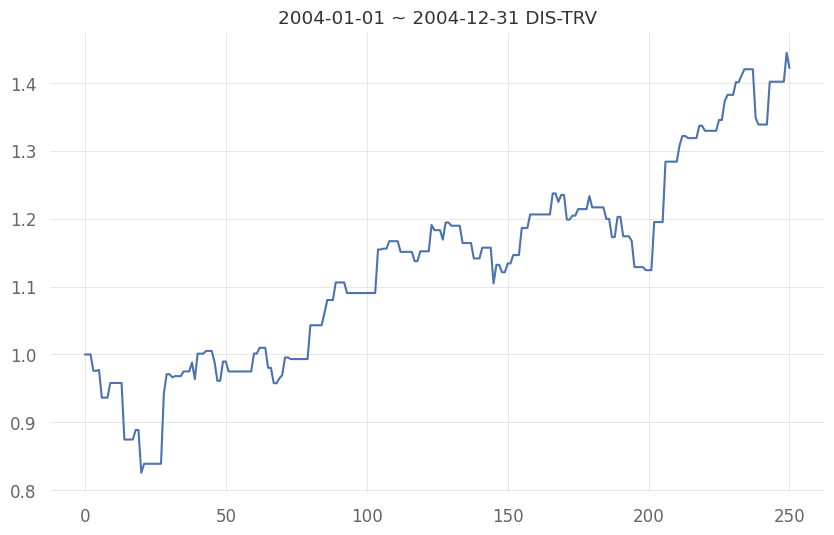

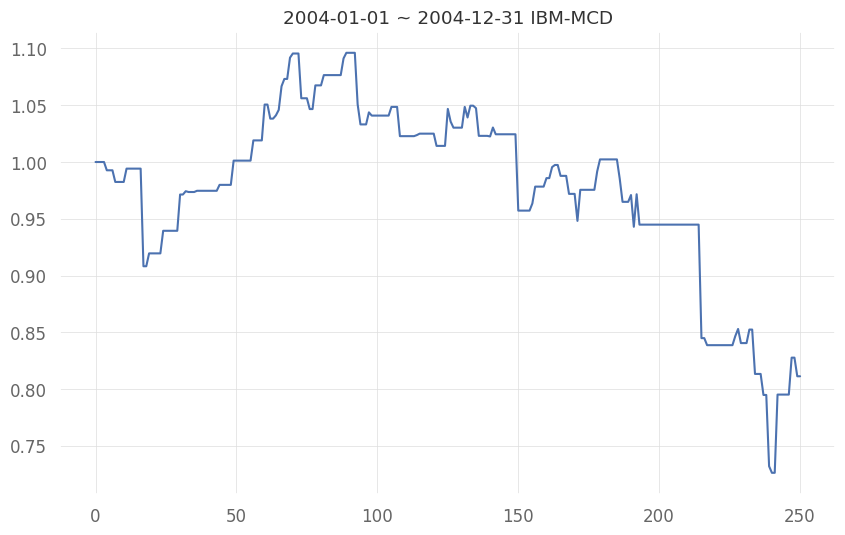

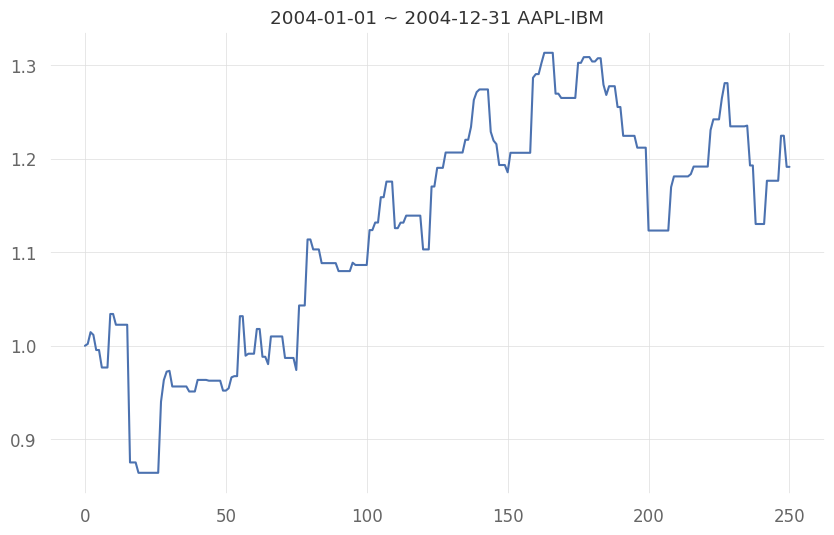

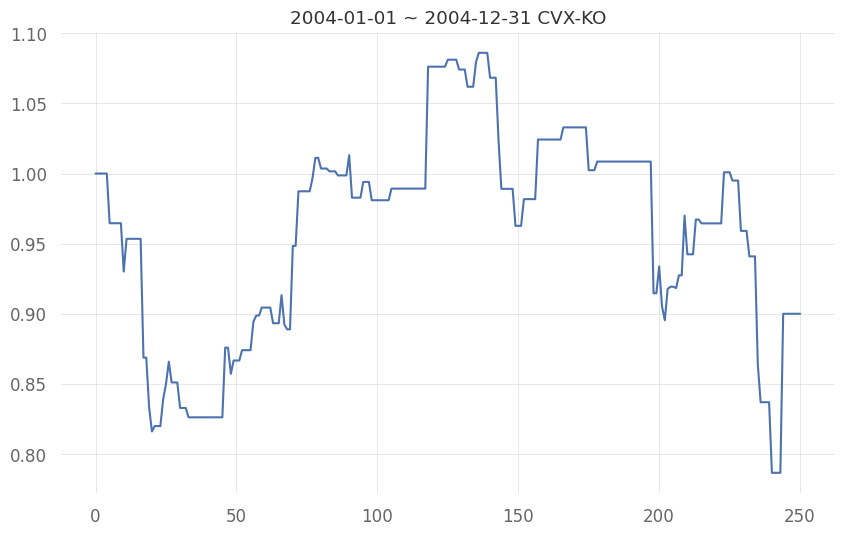

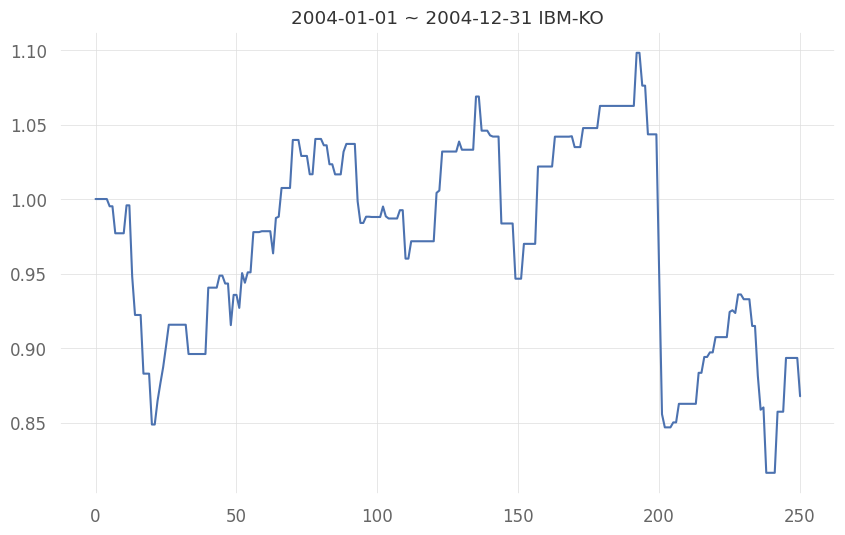

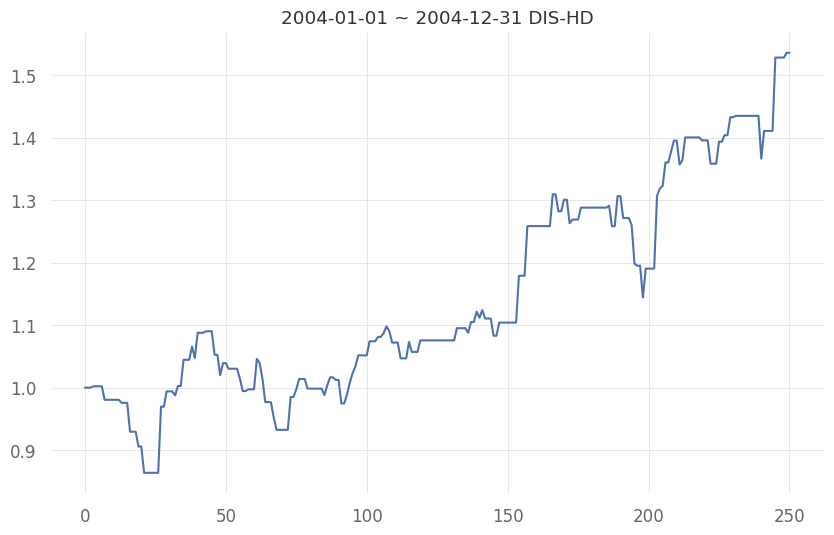

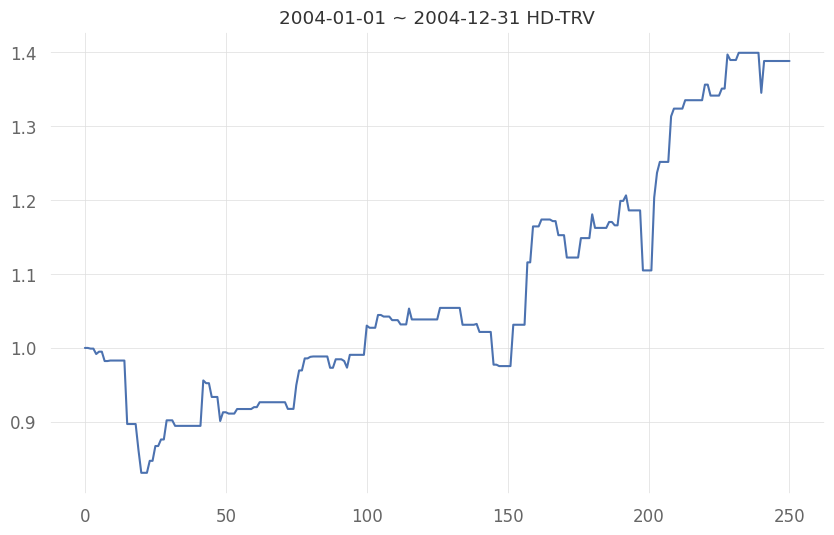

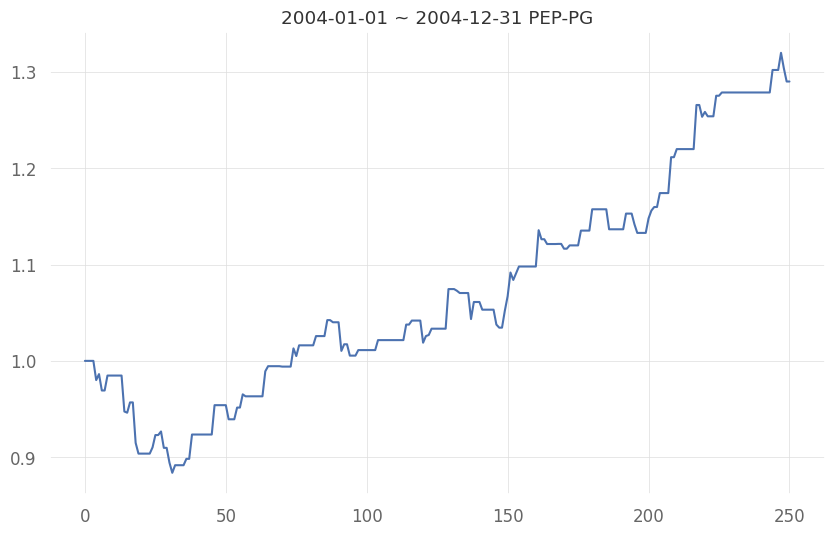

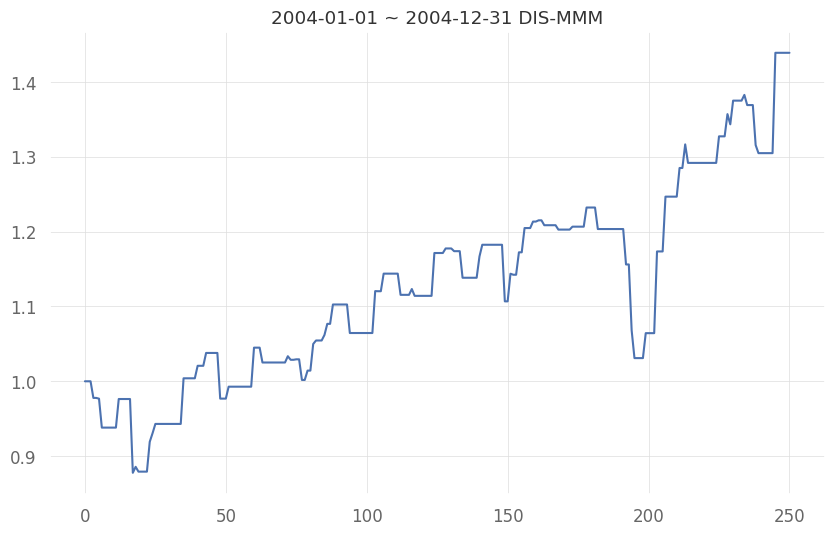

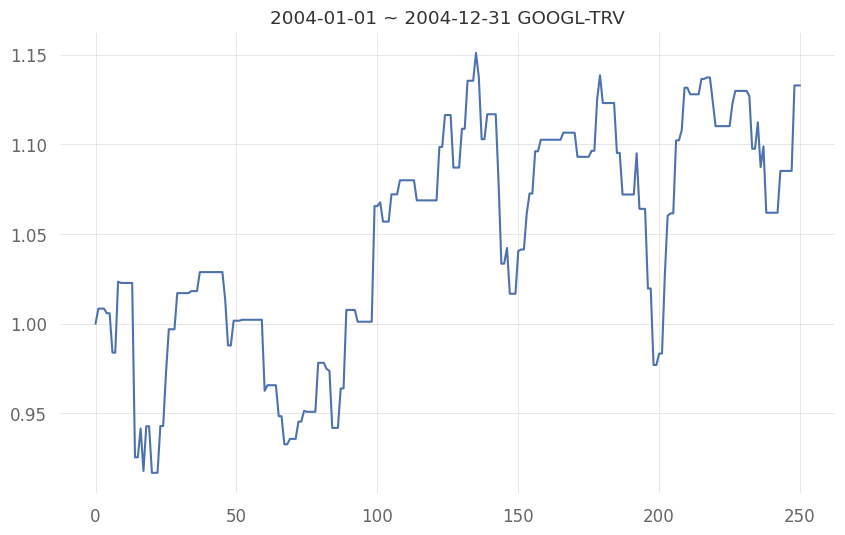

1.526775496950135


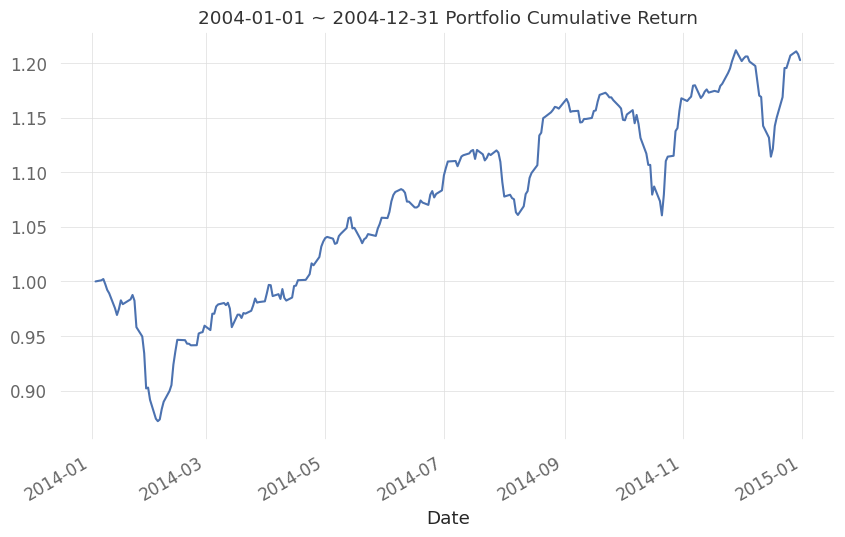

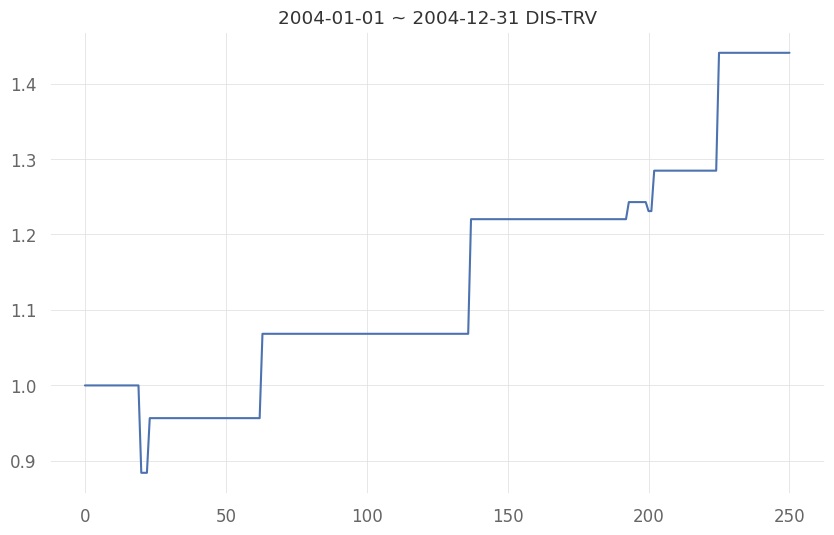

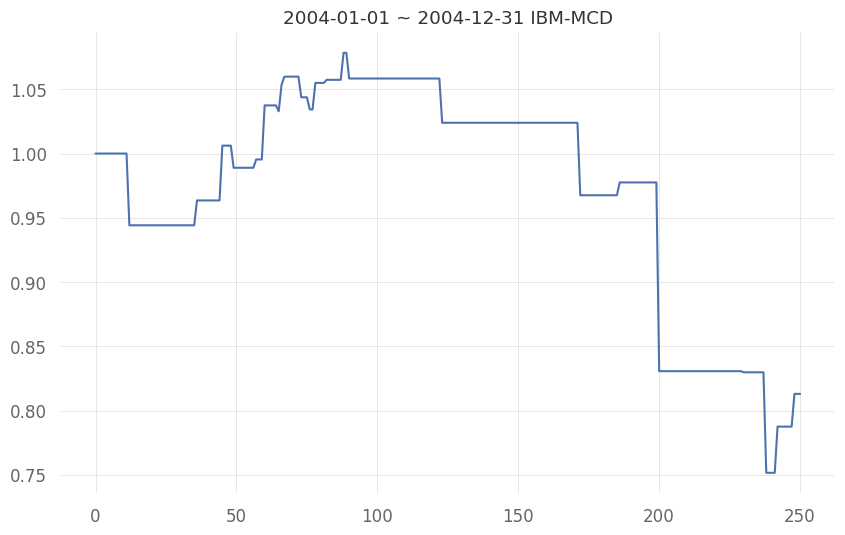

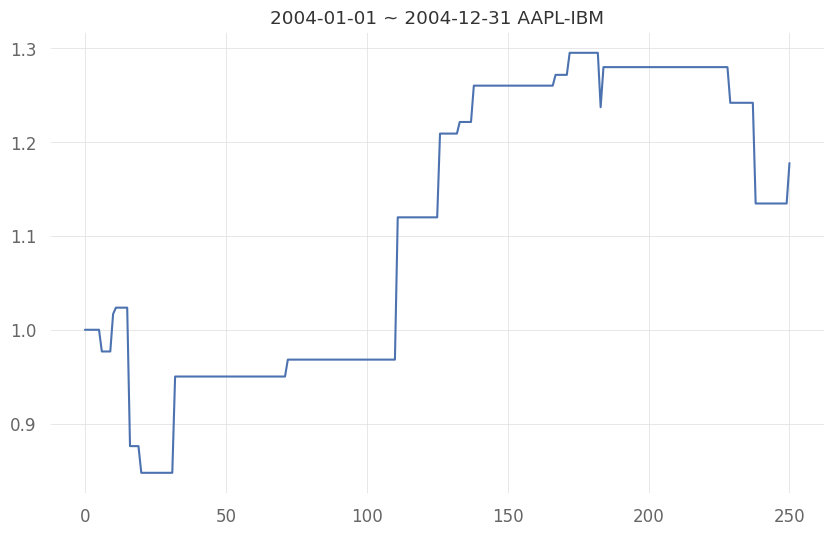

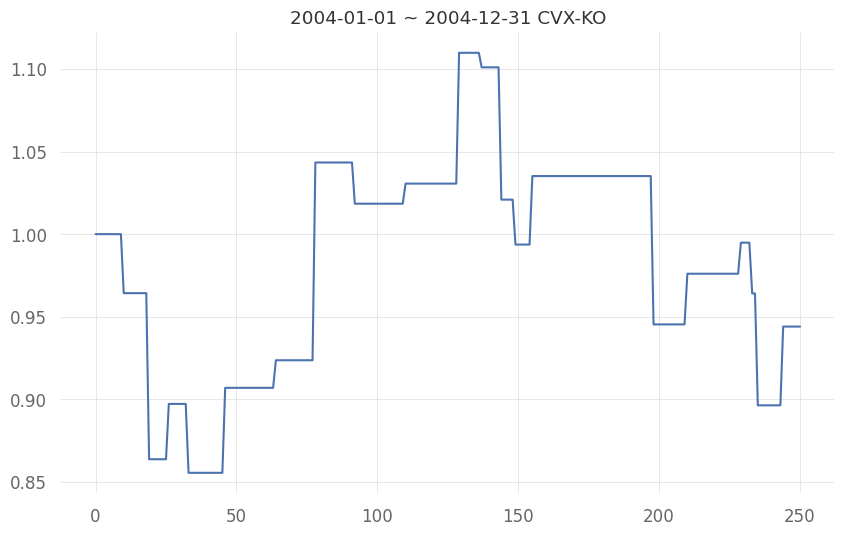

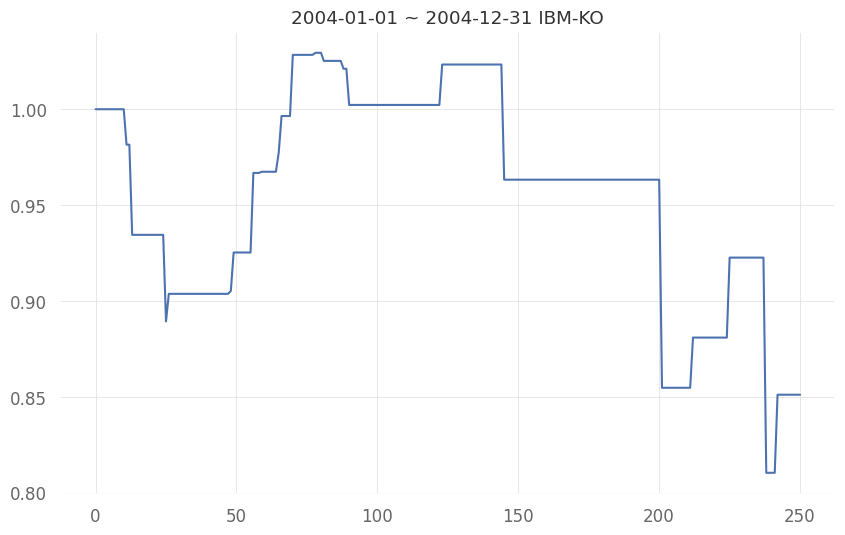

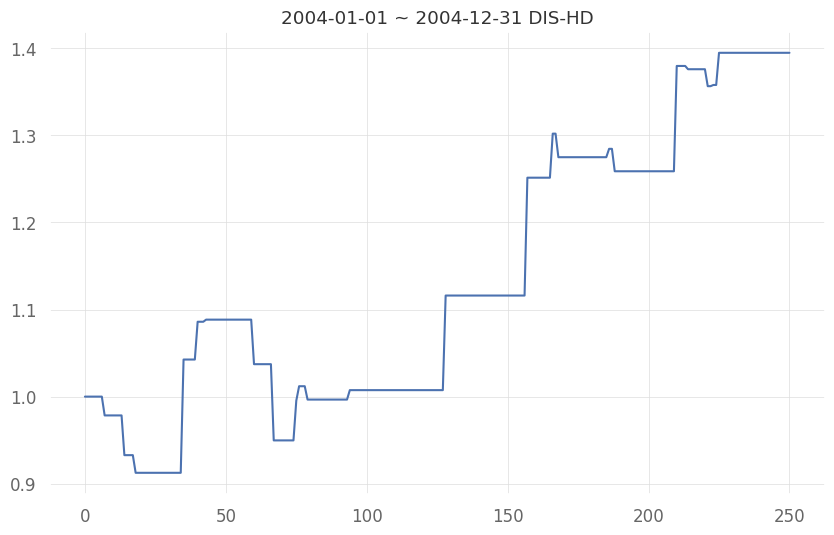

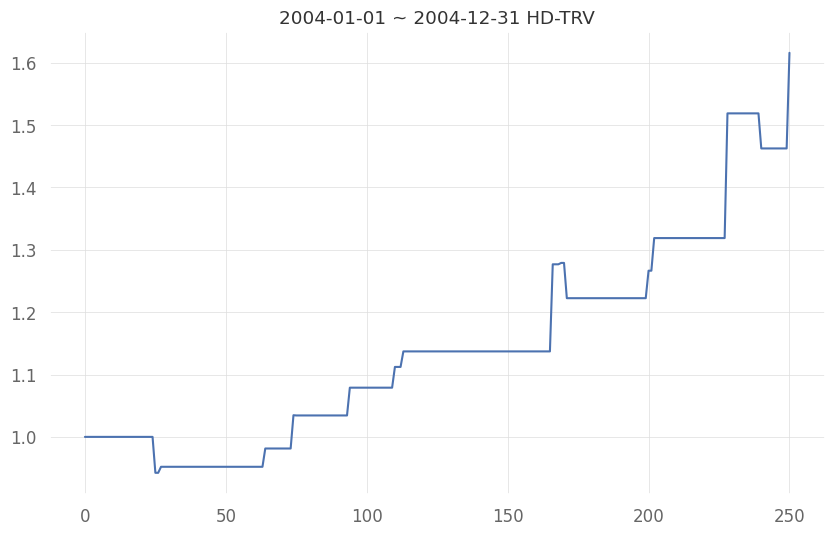

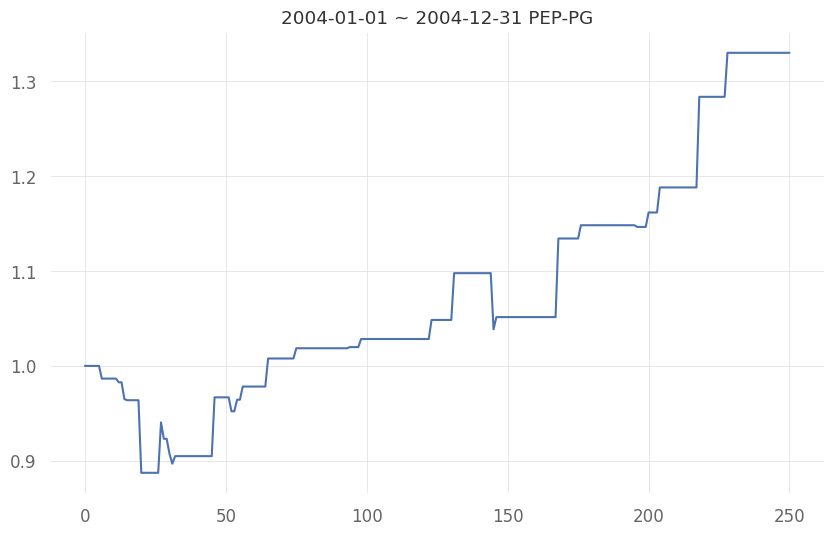

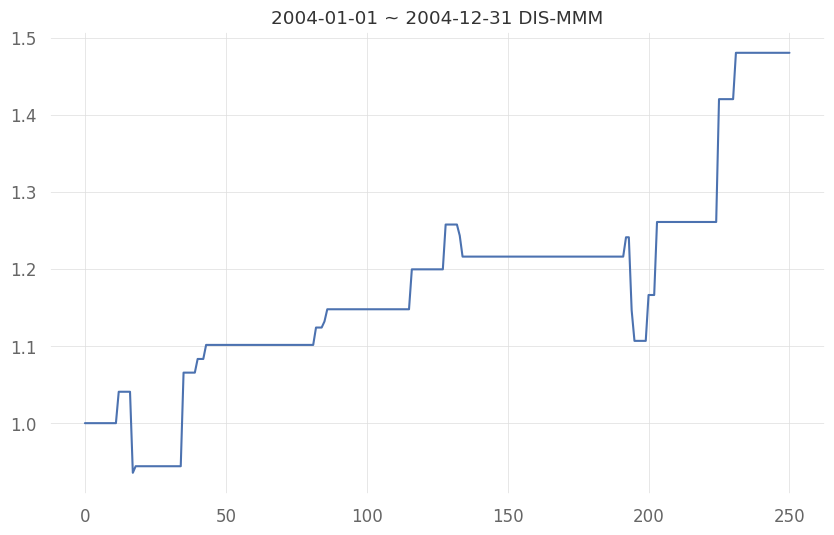

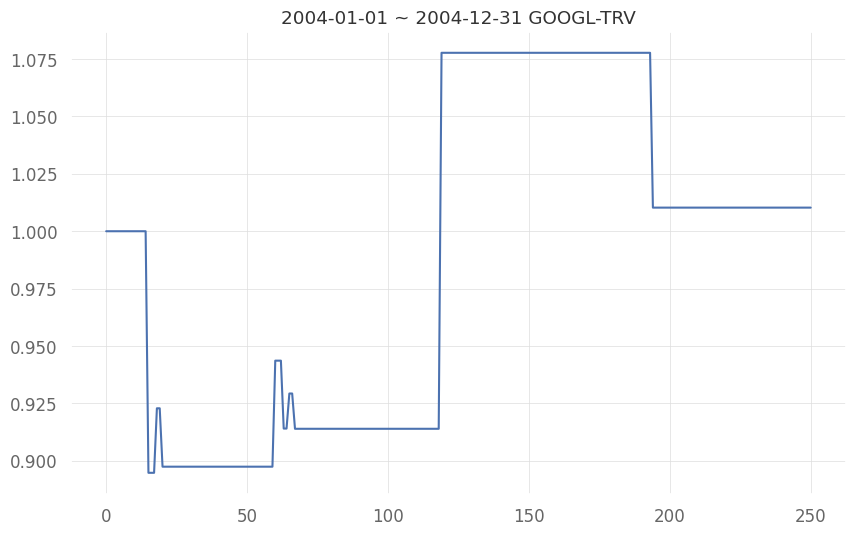

2.0466134801525437


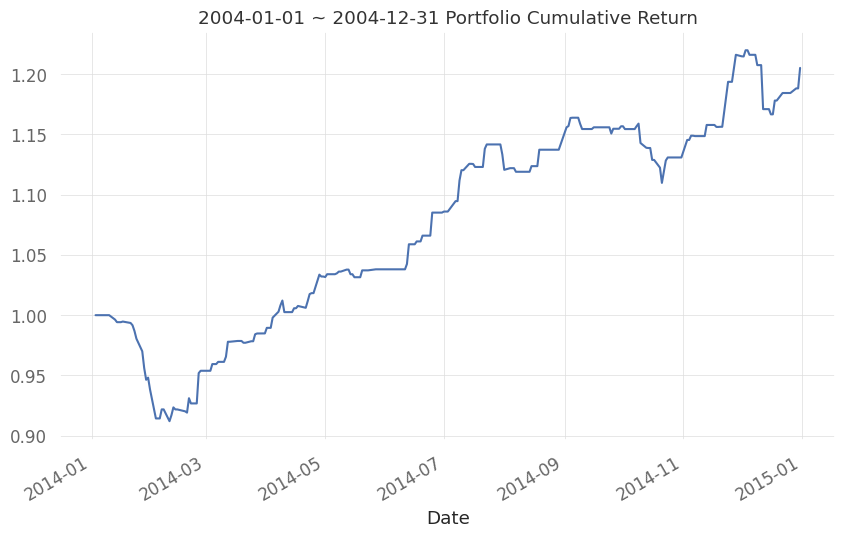

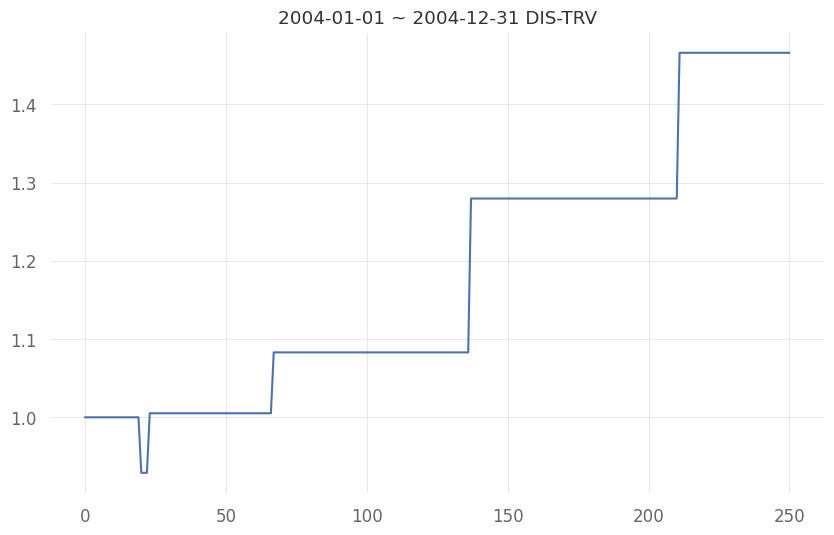

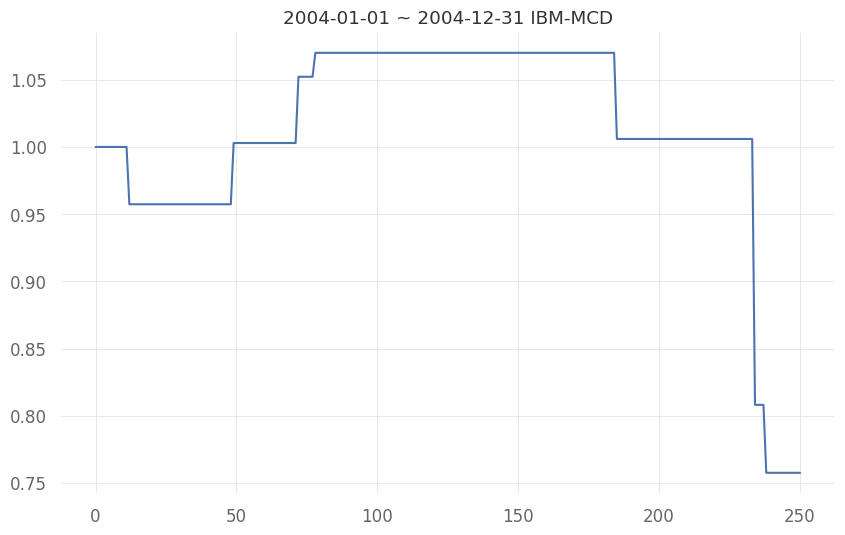

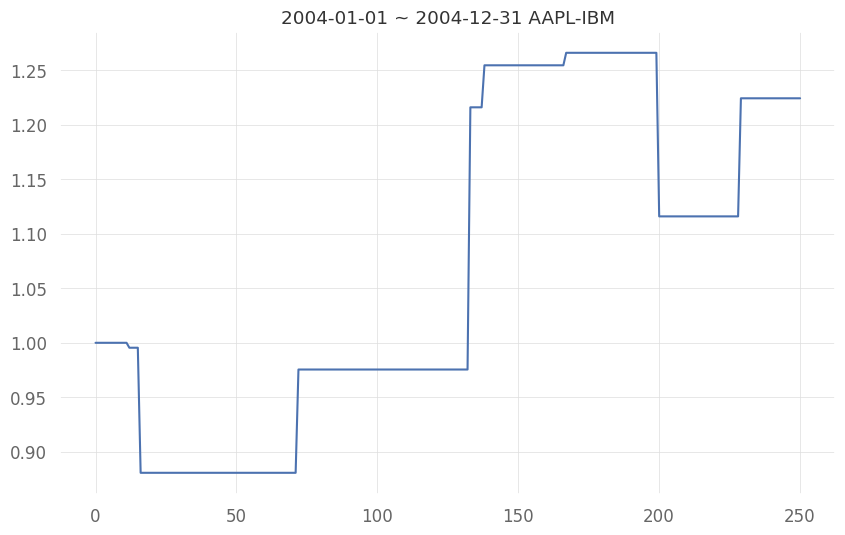

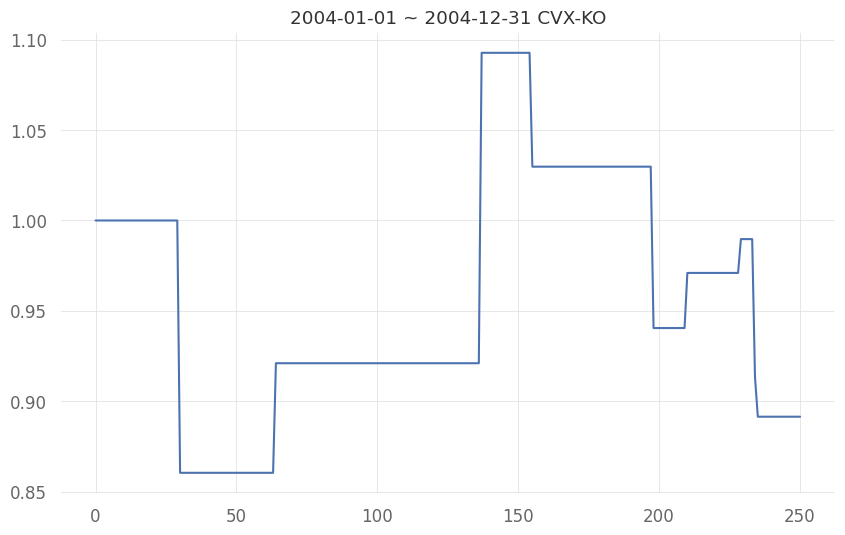

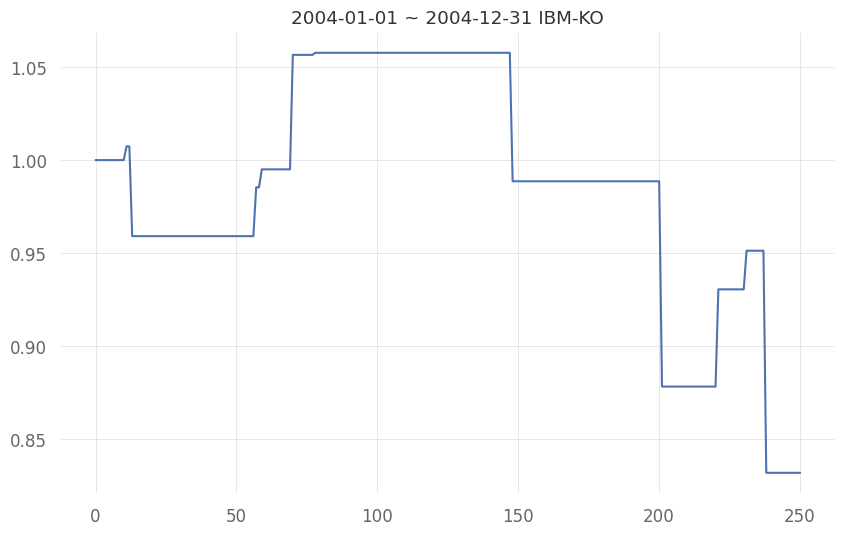

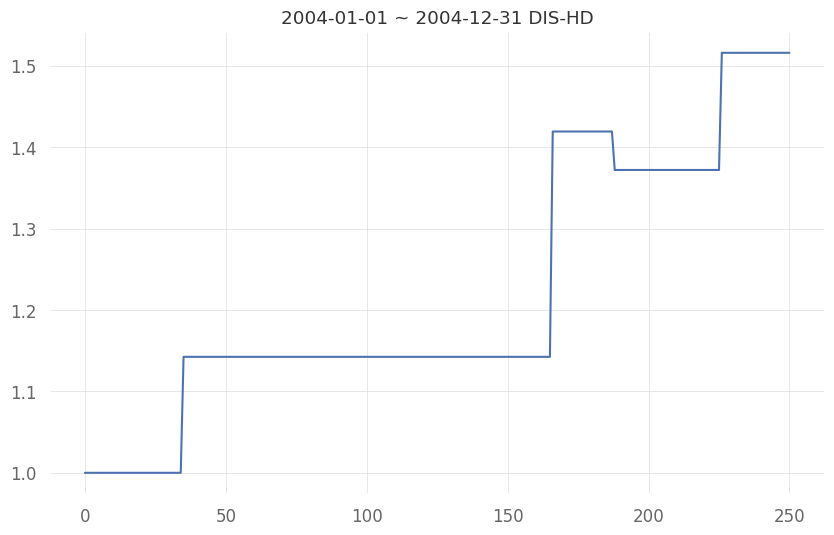

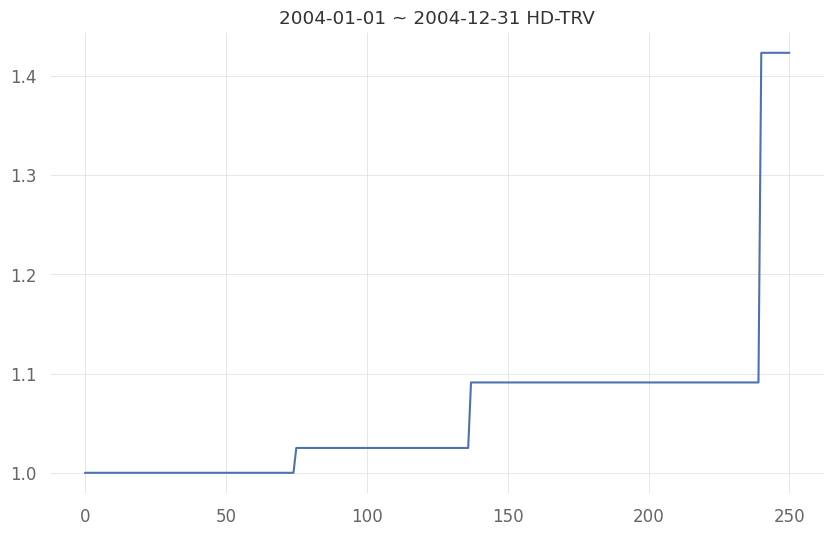

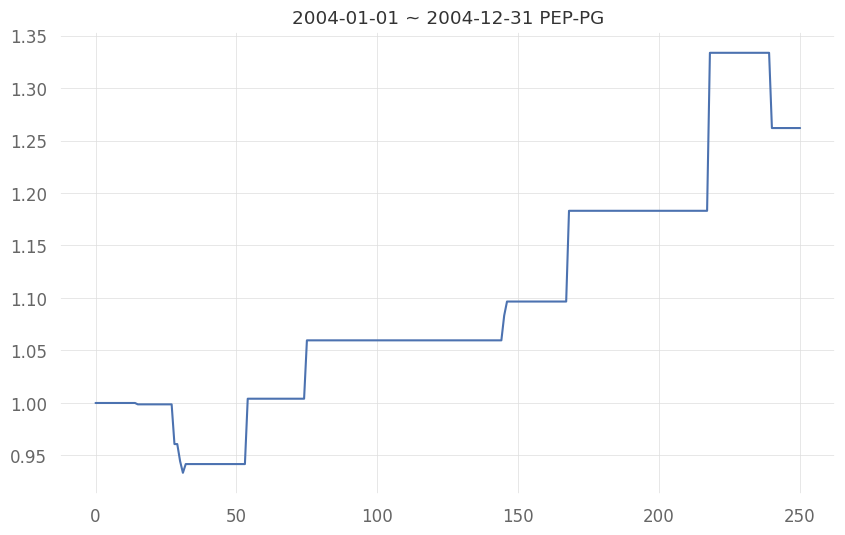

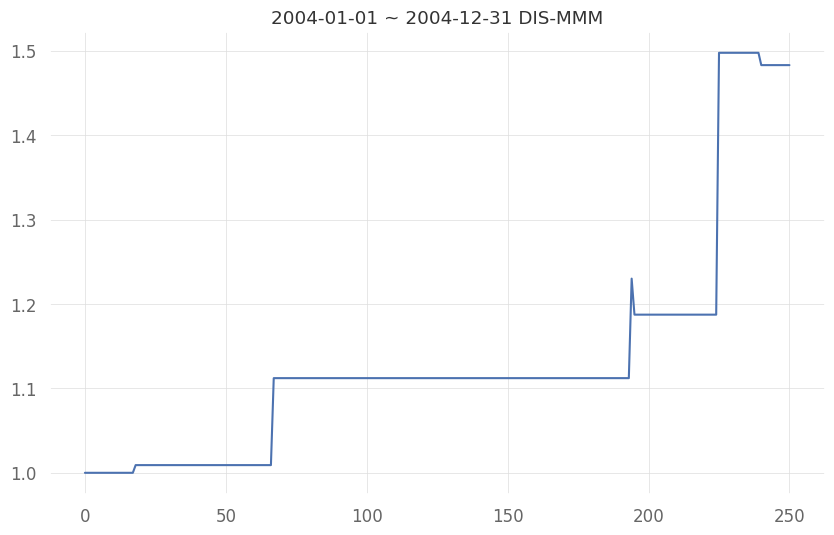

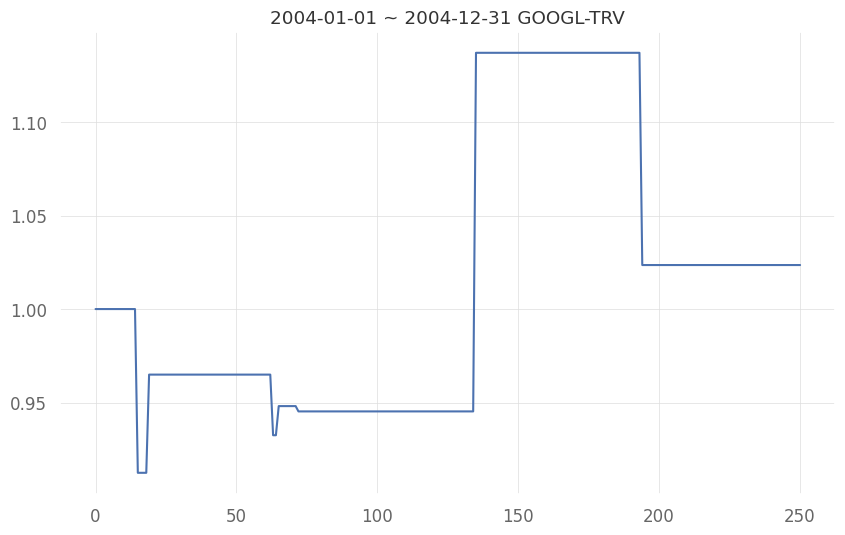

1.9063042111481532


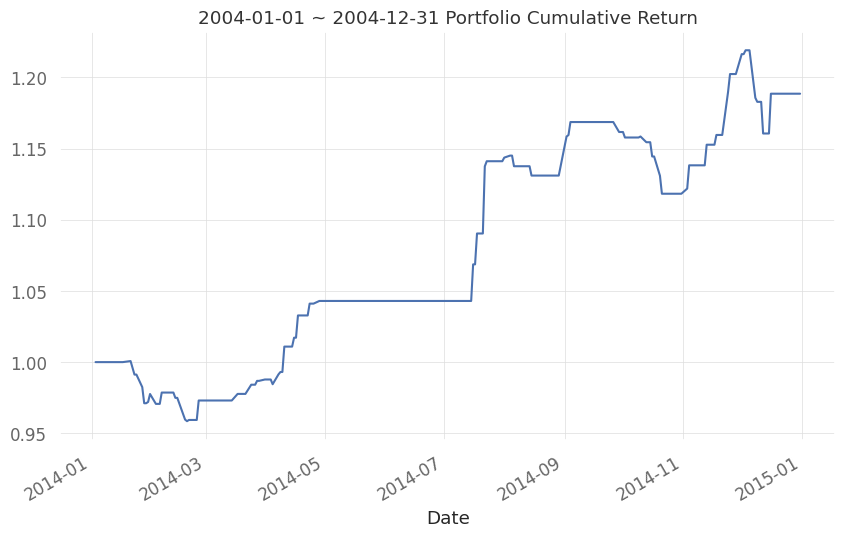

In [15]:
strategys = [1,2,3]
aa_list = range(0,10)

signal = [[]]*len(aa_list)
A_SoldPrice = [[]]*len(aa_list)
A_BoughtPrice = [[]]*len(aa_list)
B_SoldPrice = [[]]*len(aa_list)
B_BoughtPrice = [[]]*len(aa_list)
signal_time =[[]]*len(aa_list)

for strategy in strategys:
    # print(strategy)
    
    portfolio = [[]]*len(aa_list)

    for aa in aa_list: 
        results = {'signals':[],
                'returns':[],
                'i':[0],
                'A_SoldPrices':[],
                'A_BoughtPrices':[],
                'B_SoldPrices':[],
                'B_BoughtPrices':[],
                'signal_times':[]
                }

        #配對名稱
        # aa = 0
        pairlist = target_df.index[aa].split(",")
        pairname = pairlist[0]+"-"+pairlist[1]
        #配對股價
        pair_df_test_p = db.loc["2014":"2014",pairlist] 

        pair_df_test_r = db.loc["2014":"2014",pairlist].pct_change(1)*100 #配對報酬 (%)
        pair_df_test_r[pairname] = pair_df_test_r[pairlist[0]] - pair_df_test_r[pairlist[1]] #配對報酬 Spread

        pair_df_test = pd.concat([pair_df_test_p, pair_df_test_r], axis = 1).dropna() #去 na
        pair_df_test.columns = [pairlist[0]+'_P', pairlist[1]+'_P', pairlist[0]+'_R', pairlist[1]+'_R', pairname+'_S'] #rename columns
        pair_df_test

        #strategy1
        #pair1
        #i = 0
        bound = np.array(target_df.iloc[aa, 2*strategy-1:2*strategy+1]) #c2,c1
        for j in range(len(pair_df_test)): #len(pair_df_test)
            y1 = pair_df_test.iloc[j, 4] #spread
            p1 = pair_df_test.iloc[j, 0] #stock1 price
            p2 = pair_df_test.iloc[j, 1] #stock2 price
            t = pair_df_test.index[j]
            # print(y1, bound, p1,  p2)
            trade(y1, bound, p1, p2, i, t)
        # results

        new_results = pd.Series(results['returns'])
        portfolio[aa] = new_results
        
        if strategy == 1:
            new_signals = pd.Series(results['signals'])
            new_signal_times = pd.Series(results['signal_times'])
            A_SoldPrices = pd.Series(results['A_SoldPrices'])
            A_BoughtPrices = pd.Series(results['A_BoughtPrices'])
            B_SoldPrices = pd.Series(results['B_SoldPrices'])
            B_BoughtPrices = pd.Series(results['B_BoughtPrices'])
            A_SoldPrice[aa] = A_SoldPrices
            A_BoughtPrice[aa] = A_BoughtPrices
            B_SoldPrice[aa] = B_SoldPrices
            B_BoughtPrice[aa] = B_BoughtPrices
            signal[aa] = new_signals
            signal_time[aa] = new_signal_times

        (1+new_results).cumprod().plot()
        plt.title('2004-01-01 ~ 2004-12-31 '+ str(pairname))
        plt.savefig('Cumulative_Return_'+str(pairname)+'_Strategy'+str(strategy)+'.png')
        plt.show()

    portfolio_return = np.mean(portfolio, axis = 0)
    portfolio_return = pd.Series(portfolio_return)
    portfolio_return.index = pair_df_test.index
    (1+portfolio_return).cumprod().plot()
    print(qs.stats.sharpe(portfolio_return))

    plt.title('2004-01-01 ~ 2004-12-31 Portfolio Cumulative Return')
    plt.savefig('Portfolio_Cumulative_Return_Strategy'+'_Strategy'+str(strategy)+'.png')
    plt.show()

In [16]:
A_SoldPrice

[0     76.339996
 1     75.389999
 2     74.209999
 3     73.220001
 4     71.050003
 5     79.230003
 6     79.190002
 7     80.809998
 8     81.709999
 9     81.379997
 10    81.389999
 11    81.570000
 12    79.570000
 13    77.620003
 14    78.949997
 15    79.339996
 16    81.599998
 17    81.050003
 18    84.610001
 19    83.300003
 20    83.900002
 21    86.440002
 22    87.220001
 23    85.029999
 24    87.150002
 25    87.239998
 26    86.849998
 27    89.279999
 28    90.800003
 29    90.940002
 30    89.970001
 31    90.489998
 32    88.830002
 33    88.449997
 34    86.269997
 35    83.830002
 36    89.930000
 37    91.000000
 38    90.489998
 39    90.580002
 40    92.510002
 41    93.760002
 42    91.489998
 43    92.889999
 44    94.190002
 dtype: float64,
 0     178.432129
 1     177.743790
 2     168.642441
 3     169.455063
 4     176.156784
 5     175.965576
 6     177.638626
 7     185.946457
 8     185.965576
 9     187.992355
 10    189.072662
 11    183.814529
 1

In [17]:
signal_time

[0    2014-01-07
 1    2014-01-08
 2    2014-01-10
 3    2014-01-13
 4    2014-01-16
         ...    
 84   2014-12-12
 85   2014-12-15
 86   2014-12-19
 87   2014-12-30
 88   2014-12-31
 Length: 89, dtype: datetime64[ns],
 0    2014-01-03
 1    2014-01-09
 2    2014-01-14
 3    2014-01-21
 4    2014-01-29
         ...    
 74   2014-12-15
 75   2014-12-16
 76   2014-12-18
 77   2014-12-26
 78   2014-12-30
 Length: 79, dtype: datetime64[ns],
 0    2014-01-03
 1    2014-01-06
 2    2014-01-07
 3    2014-01-08
 4    2014-01-09
         ...    
 88   2014-12-10
 89   2014-12-12
 90   2014-12-18
 91   2014-12-26
 92   2014-12-30
 Length: 93, dtype: datetime64[ns],
 0    2014-01-03
 1    2014-01-10
 2    2014-01-17
 3    2014-01-21
 4    2014-01-29
         ...    
 67   2014-12-04
 68   2014-12-09
 69   2014-12-10
 70   2014-12-16
 71   2014-12-22
 Length: 72, dtype: datetime64[ns],
 0    2014-01-03
 1    2014-01-10
 2    2014-01-14
 3    2014-01-21
 4    2014-01-23
         ...    
 86   

In [18]:
strategy4 = { 'signal':[],
              'A_sell': [],
              'B_buy':[],
              'A_buy':[],
              'B_sell':[],
              'signal_time':[] 
}
for i in range(0,len(signal)):
    tmp = signal[i][0]
    strategy4['signal'].append(tmp)
    strategy4['signal_time'].append(signal_time[i][0])
    if tmp == 1 :
        strategy4['A_sell'].append(A_SoldPrice[i][0])
        strategy4['B_buy'].append(B_BoughtPrice[i][0])
        strategy4['A_buy'].append(0)
        strategy4['B_sell'].append(0)
    else:
        strategy4['A_sell'].append(0)
        strategy4['B_buy'].append(0)
        strategy4['A_buy'].append(A_BoughtPrice[i][0])
        strategy4['B_sell'].append(B_SoldPrice[i][0])

strategy4 = pd.DataFrame(strategy4)
strategy4.index = target_df.index



In [19]:
strategy4

,signal,A_sell,B_buy,A_buy,B_sell,signal_time
"DIS,TRV",1,76.339996,88.400002,0.000000,0.000000,2014-01-07
"IBM,MCD",1,178.432129,96.540001,0.000000,0.000000,2014-01-03
"AAPL,IBM",-1,0.000000,0.000000,19.320715,178.432129,2014-01-03
"CVX,KO",1,124.349998,40.459999,0.000000,0.000000,2014-01-03
"IBM,KO",1,178.432129,40.459999,0.000000,0.000000,2014-01-03
"DIS,HD",1,75.820000,81.099998,0.000000,0.000000,2014-01-06
"HD,TRV",-1,0.000000,0.000000,81.099998,88.919998,2014-01-06
"PEP,PG",1,83.480003,81.419998,0.000000,0.000000,2014-01-07
"DIS,MMM",1,76.339996,137.649994,0.000000,0.000000,2014-01-07
"GOOGL,TRV",-1,0.000000,0.000000,27.652653,89.160004,2014-01-03


In [20]:
a=db.loc["2014":"2014", target_df.index[0].split(',')[1]]#[-1]
a

Date
2014-01-02     89.330002
2014-01-03     89.160004
2014-01-06     88.919998
2014-01-07     88.400002
2014-01-08     87.580002
                 ...    
2014-12-24    106.720001
2014-12-26    106.699997
2014-12-29    106.949997
2014-12-30    106.930000
2014-12-31    105.849998
Name: TRV, Length: 252, dtype: float64

In [21]:
tmp1 = []
tmp2 = []
for i in range(0,len(strategy4)):  
    tmp1.append(db.loc["2014":"2014", target_df.index[i].split(',')[0]][-1])
    tmp2.append(db.loc["2014":"2014", target_df.index[i].split(',')[1]][-1])
strategy4['StockA_T'] = tmp1
strategy4['StockB_T'] = tmp2
strategy4

,signal,A_sell,B_buy,A_buy,B_sell,signal_time,StockA_T,StockB_T
"DIS,TRV",1,76.339996,88.400002,0.000000,0.000000,2014-01-07,94.190002,105.849998
"IBM,MCD",1,178.432129,96.540001,0.000000,0.000000,2014-01-03,153.384323,93.699997
"AAPL,IBM",-1,0.000000,0.000000,19.320715,178.432129,2014-01-03,27.594999,153.384323
"CVX,KO",1,124.349998,40.459999,0.000000,0.000000,2014-01-03,112.180000,42.220001
"IBM,KO",1,178.432129,40.459999,0.000000,0.000000,2014-01-03,153.384323,42.220001
"DIS,HD",1,75.820000,81.099998,0.000000,0.000000,2014-01-06,94.190002,104.970001
"HD,TRV",-1,0.000000,0.000000,81.099998,88.919998,2014-01-06,104.970001,105.849998
"PEP,PG",1,83.480003,81.419998,0.000000,0.000000,2014-01-07,94.559998,91.089996
"DIS,MMM",1,76.339996,137.649994,0.000000,0.000000,2014-01-07,94.190002,164.320007
"GOOGL,TRV",-1,0.000000,0.000000,27.652653,89.160004,2014-01-03,26.533001,105.849998


In [22]:
a = strategy4['signal'][0]
a

1

In [23]:
tmp = []
for i in range(0,len(strategy4)):
    if strategy4['signal'][i] == 1:
        tmp.append(-((strategy4['StockA_T'][i]-strategy4['A_sell'][i])/strategy4['A_sell'][i]) + (strategy4['StockB_T'][i]-strategy4['B_buy'][i])/strategy4['B_buy'][i])
    else:
        tmp.append(-((strategy4['StockB_T'][i]-strategy4['B_sell'][i])/strategy4['B_sell'][i]) + (strategy4['StockA_T'][i]-strategy4['A_buy'][i])/strategy4['A_buy'][i])
strategy4['return'] = tmp

strategy4


,signal,A_sell,B_buy,A_buy,B_sell,signal_time,StockA_T,StockB_T,return
"DIS,TRV",1,76.339996,88.400002,0.000000,0.000000,2014-01-07,94.190002,105.849998,-0.036424
"IBM,MCD",1,178.432129,96.540001,0.000000,0.000000,2014-01-03,153.384323,93.699997,0.110959
"AAPL,IBM",-1,0.000000,0.000000,19.320715,178.432129,2014-01-03,27.594999,153.384323,0.568637
"CVX,KO",1,124.349998,40.459999,0.000000,0.000000,2014-01-03,112.180000,42.220001,0.141369
"IBM,KO",1,178.432129,40.459999,0.000000,0.000000,2014-01-03,153.384323,42.220001,0.183877
"DIS,HD",1,75.820000,81.099998,0.000000,0.000000,2014-01-06,94.190002,104.970001,0.052044
"HD,TRV",-1,0.000000,0.000000,81.099998,88.919998,2014-01-06,104.970001,105.849998,0.103932
"PEP,PG",1,83.480003,81.419998,0.000000,0.000000,2014-01-07,94.559998,91.089996,-0.013959
"DIS,MMM",1,76.339996,137.649994,0.000000,0.000000,2014-01-07,94.190002,164.320007,-0.040070
"GOOGL,TRV",-1,0.000000,0.000000,27.652653,89.160004,2014-01-03,26.533001,105.849998,-0.227681


In [24]:
import datetime as dt

0.9603562952206922

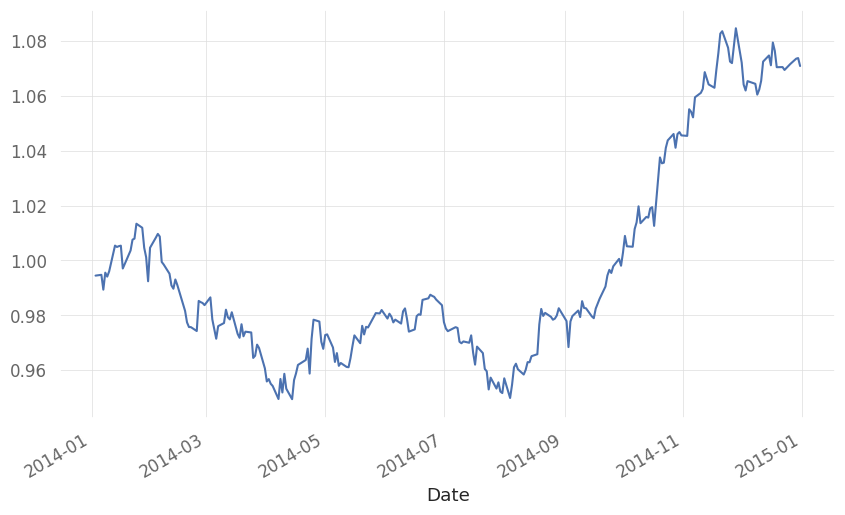

In [25]:
portfolio = [[]]*len(aa_list)
for aa in range(0, len(strategy4)):
    
    #配對名稱
    pairlist = strategy4.index[aa].split(",")
    pairname = pairlist[0]+"-"+pairlist[1]
    #配對股價
    pair_df_test_p = db.loc["2014":"2014",pairlist] 

    pair_df_test_r = db.loc["2014":"2014",pairlist].pct_change(1)*100 #配對報酬 (%)
    pair_df_test_r[pairname] = pair_df_test_r[pairlist[0]] - pair_df_test_r[pairlist[1]] #配對報酬 Spread

    pair_df_test = pd.concat([pair_df_test_p, pair_df_test_r], axis = 1).dropna() #去 na
    pair_df_test.columns = [pairlist[0]+'_P', pairlist[1]+'_P', pairlist[0]+'_R', pairlist[1]+'_R', pairname+'_S'] #rename columns
    pair_df_test

    signal = strategy4.iloc[aa,0]
    entry = strategy4.iloc[aa,5]+dt.timedelta(days=-1)

    if signal == 1:
        pair_df_test[pairlist[0]+'_R'] = -pair_df_test[pairlist[0]+'_R']
    else:
        pair_df_test[pairlist[1]+'_R'] = -pair_df_test[pairlist[1]+'_R']
    
    #calculate long-short return
    pair_df_test[pairlist[0]+"_"+pairlist[1]+"_LSR"] = pair_df_test[pairlist[0]+'_R'] + pair_df_test[pairlist[1]+'_R']
    pair_df_test.loc[:entry,pairlist[0]+"_"+pairlist[1]+"_LSR"] = np.array([0]*len(pair_df_test.loc[:entry,:]))

    portfolio[aa] = pair_df_test[pairlist[0]+"_"+pairlist[1]+"_LSR"]/100


    
#pair_df_test

portfolio_return = np.mean(portfolio, axis = 0)
portfolio_return = pd.Series(portfolio_return)
portfolio_return.index = pair_df_test.index
(1+portfolio_return).cumprod().plot()

qs.stats.sharpe(portfolio_return)

In [26]:
portfolio_return

Date
2014-01-03   -0.005549
2014-01-06    0.000290
2014-01-07   -0.005432
2014-01-08    0.006263
2014-01-09   -0.001453
                ...   
2014-12-24    0.000687
2014-12-26    0.001371
2014-12-29    0.001790
2014-12-30    0.000199
2014-12-31   -0.002690
Length: 251, dtype: float64

<AxesSubplot: xlabel='Date'>

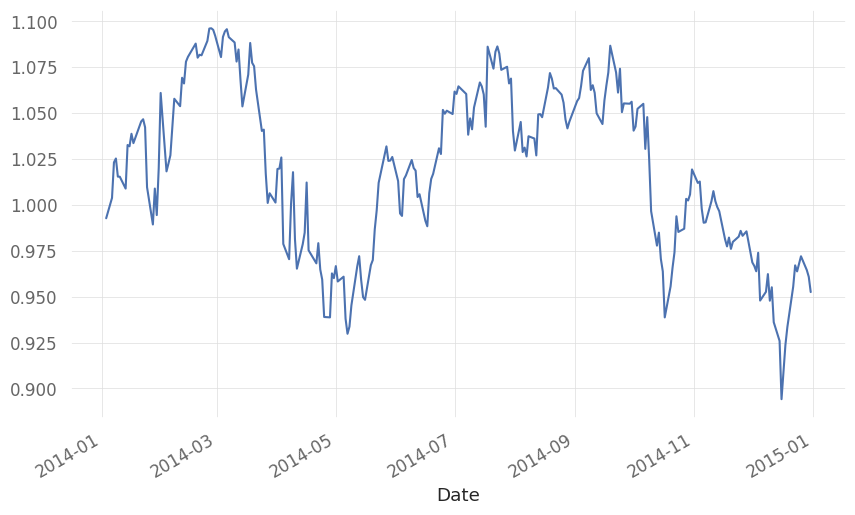

In [27]:
(1+pair_df_test_r[pairlist[0]]/100).cumprod().plot()

<AxesSubplot: xlabel='Date'>

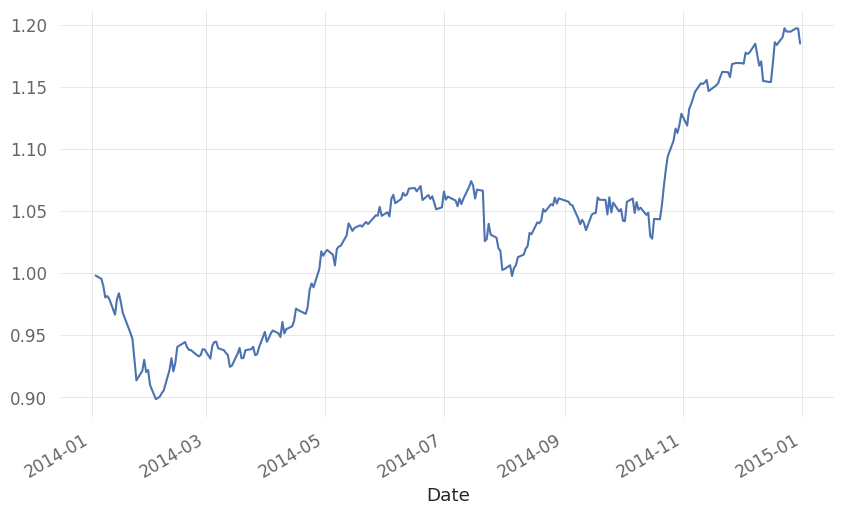

In [28]:
(1+pair_df_test_r[pairlist[1]]/100).cumprod().plot()

In [29]:
qs.stats.sharpe(portfolio_return)

0.9603562952206922

In [30]:
# np.array([1/len(aa_list)]*len(aa_list))

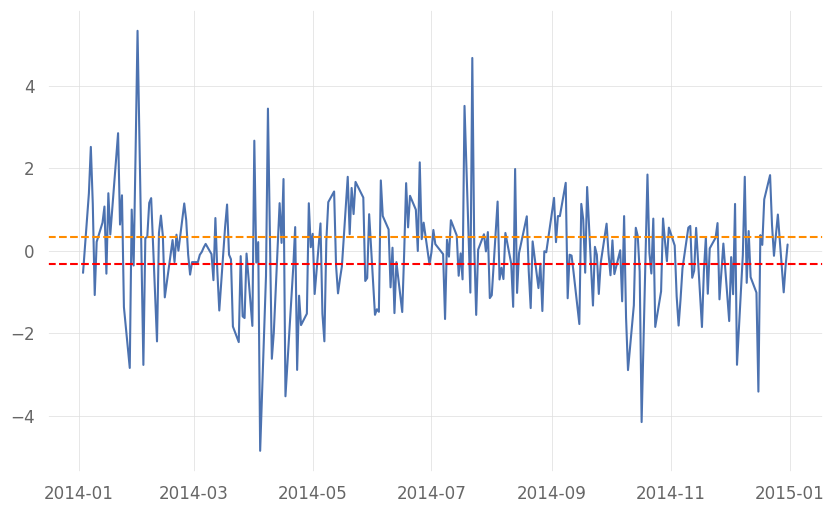

In [36]:
#畫圖
import matplotlib.pyplot as plt

plt.plot(pair_df_test.index,pair_df_test[pairlist[0]+"-"+pairlist[1]+'_S'])
plt.axhline(y=target_df.iloc[0,1],label='c2',linestyle='--',color = 'darkorange')
plt.axhline(y=target_df.iloc[0,2],label='c1',linestyle='--',color = 'red')

In [32]:
global results
global i

In [33]:
# #畫圖
# import matplotlib.pyplot as plt

# plt.plot(pair_df_test.index,pair_df_test[pair_df_test.keys()[-1]])
         
# plt.axhline(y=target_df.iloc[0,1],label='upper',linestyle='--',color = 'darkorange')
# plt.axhline(y=target_df.iloc[0,2],label='lower',linestyle='--',color = 'red')

In [34]:
# del results['signals']
# del results['i']
# del results['A_SoldPrices']
# del results['A_BoughtPrices']
# del results['B_SoldPrices']
# del results['B_BoughtPrices']

In [35]:
qs.stats.sharpe(new_results)


0.21094309522012927